In [37]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [38]:
X = np.load('x_letters.npy')
Y = np.load('y_letters.npy')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])


In [39]:
def build_discriminator(img_dim, num_classes):
    image_input= layers.Input(shape=(img_dim, img_dim))
    label_input= layers.Input(shape=(num_classes,))
    flat_image= layers.Flatten()(image_input)
    concat= layers.Concatenate()([flat_image, label_input])
    x = layers.Dense(4, activation="relu", kernel_initializer="he_normal")(concat)
    x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting

    real_or_fake= layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([image_input, label_input], real_or_fake)

In [40]:

def build_generator(img_dim, num_classes, latent_dim):
    # Input layers
    latent_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(num_classes,))

    # Concatenate latent and label inputs
    concat = layers.Concatenate()([latent_input, label_input])

    # Fully connected layers
    x = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(concat)
    x = layers.LeakyReLU(negative_slope=0.1)(x)  # LeakyReLU is often used in GANs

    # Final layer to reshape the output to the desired image size
    output = layers.Dense(img_dim * img_dim, activation='tanh')(x)  # tanh for scaled output (-1 to 1)
    generated_image = layers.Reshape((img_dim, img_dim,1))(output)
    return tf.keras.Model([latent_input, label_input], generated_image)



In [41]:
img_dim = 28
num_classes = 26
latent_dim = 32

dis = build_discriminator(img_dim, num_classes)
gen = build_generator(img_dim, num_classes, latent_dim)

In [46]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_labels = data  # Unpack the data (images and their labels)
        
        batch_size = tf.shape(real_images)[0]

        # 1. Train the Discriminator:
        # --------------------------------

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Generate random labels for the generated images
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )
        random_labels = tf.one_hot(random_labels, self.num_classes)

        # Generate fake images conditioned on these random labels
        generated_images = self.generator([random_latent_vectors, random_labels])

        # Combine real and fake images and their labels
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_labels = tf.concat([random_labels, real_labels], axis=0)

        real_fake_labels = tf.concat(
            [tf.ones((batch_size, 1)) * 0.9,  # Real labels smoothed (0.9 instead of 1)
            tf.zeros((batch_size, 1)) + 0.1],  # Fake labels smoothed (0.1 instead of 0)
            axis=0
        )
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(real_fake_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # 2. Train the Generator:
        # --------------------------------
        # Sample random points in the latent space again
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Generate random labels again
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )
        random_labels = tf.one_hot(random_labels, self.num_classes)

        # Assemble labels that say "all real images" (i.e., we want the generator to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, random_labels])
            predictions = self.discriminator([fake_images, random_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [49]:
epochs = 100
y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)

gan = GAN(discriminator=dis, generator=gen, latent_dim=latent_dim, num_classes=num_classes)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001, clipvalue=1.0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(X_train, y_train, epochs=epochs)

Epoch 1/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - d_loss: 0.3427 - g_loss: 0.1052
Epoch 2/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3333 - g_loss: 0.1053
Epoch 3/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3325 - g_loss: 0.1054
Epoch 4/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3319 - g_loss: 0.1054
Epoch 5/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3315 - g_loss: 0.1054
Epoch 6/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3311 - g_loss: 0.1053
Epoch 7/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3308 - g_loss: 0.1054
Epoch 8/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3306 - g_loss: 0.1054
Epoch 9/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3304 - g_loss: 0.1054
Epoch 10/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3301 - g_loss: 0.1054
Epoch 11/100
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - d_loss: 0.3299 - g_loss: 0.1054
Epoch 12/100
2220/2

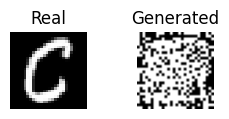

In [52]:
def generate_and_compare_image(generator, latent_dim, label, num_classes):
    # Step 1: Display the actual image from the dataset
    plt.figure(figsize=(3, 1))
    plt.subplot(1, 2, 1)
    plt.imshow(X[np.where(Y == label)[0][0]], cmap='gray', interpolation='nearest')
    plt.title("Real")
    plt.axis('off')  # Hide the axes
    
    # Step 2: Generate a random latent vector (noise)
    random_latent_vector = np.random.normal(size=(1, latent_dim))
    
    # Step 3: Create a one-hot encoded label for the condition
    one_hot_label = np.zeros((1, num_classes))
    one_hot_label[0, label] = 1  # Set the index for the class to 1 (e.g., class 'label')

    # Step 4: Generate an image using the generator model
    generated_image = generator([random_latent_vector, one_hot_label])

    # Step 5: Post-process the image (Rescale from [-1, 1] to [0, 1] for visualization)
    generated_image = (generated_image[0, :, :, 0] + 1) / 2.0  # Assuming it's grayscale

    # Step 6: Display the generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image, cmap='gray')
    plt.title("Generated")
    plt.axis('off')  # Turn off axis labels

    # Step 7: Show the comparison of actual vs generated images side by side
    plt.show()


generate_and_compare_image(gan.generator, latent_dim=latent_dim, label=2, num_classes=num_classes)


In [36]:

def build_generator(img_dim, num_classes, latent_dim):
    # Input layers
    latent_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(num_classes,))

    # Concatenate latent and label inputs
    concat = layers.Concatenate()([latent_input, label_input])

    # Fully connected layers
    x = layers.Dense(128 * 7 * 7, activation="relu", kernel_initializer="he_normal")(concat)
    x = layers.LeakyReLU(negative_slope=0.1)(x)  # LeakyReLU is often used in GANs
    x = layers.Reshape((7, 7, 128))(x)  # Reshape for Conv2DTranspose

    # Transposed convolutional layers to upscale the image
    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # 7x7 -> 14x14
    x = layers.BatchNormalization()(x)  # Normalize for better convergence

    x = layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # 14x14 -> 28x28
    x = layers.BatchNormalization()(x)  # Normalize for better convergence

    # Final layer to produce the output image
    generated_image = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='tanh')(x)  # 28x28x1

    return tf.keras.Model([latent_input, label_input], generated_image)



In [37]:
dis = build_discriminator(img_dim, num_classes)
gen = build_generator(img_dim, num_classes, latent_dim)

In [36]:
dis = build_discriminator(img_dim, num_classes)
gen = build_generator(img_dim, num_classes, latent_dim)

epochs = 100
y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)

gan = GAN(discriminator=dis, generator=gen, latent_dim=latent_dim, num_classes=num_classes)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001, clipvalue=1.0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(X_train, y_train, epochs=epochs)

Epoch 1/100


AttributeError: 'GAN' object has no attribute 'seed_generator'

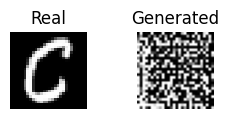

In [42]:
generate_and_compare_image(gan.generator, latent_dim=latent_dim, label=2, num_classes=num_classes)

In [34]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_labels = data  # Unpack the data (images and their labels)

        batch_size = tf.shape(real_images)[0]

        # 1. Train the Discriminator:
        # --------------------------------

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Generate random labels for the generated images (scalar integers)
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        # Generate fake images conditioned on these random labels
        generated_images = self.generator([random_latent_vectors, random_labels])

        # Cast real_labels and random_labels to float32
        real_labels = tf.reshape(tf.cast(real_labels, tf.float32), [-1])  # Ensure real_labels is 1D
        random_labels = tf.reshape(tf.cast(random_labels, tf.float32), [-1])  # Ensure random_labels is 1D

        # Check shapes before concatenation
        print("Shape of generated images:", generated_images.shape)
        print("Shape of real images:", real_images.shape)

        # Concatenate real and fake images and their corresponding labels
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_labels = tf.concat([random_labels, real_labels], axis=0)

        # Real and fake labels for the discriminator
        real_fake_labels = tf.concat(
            [tf.ones((batch_size, 1)) * 0.9,  # Real labels (0.9 instead of 1 for label smoothing)
            tf.zeros((batch_size, 1)) + 0.1],  # Fake labels (0.1 instead of 0 for label smoothing)
            axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(real_fake_labels, predictions)

        # Update discriminator weights
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # 2. Train the Generator:
        # --------------------------------
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Generate random labels again (scalar integers)
        random_labels = tf.random.uniform(
            shape=(batch_size,), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, random_labels])
            predictions = self.discriminator([fake_images, tf.cast(random_labels, tf.float32)])
            g_loss = self.loss_fn(misleading_labels, predictions)

        # Update generator weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update the loss metrics for both discriminator and generator
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }



In [35]:
img_dim = 28
num_classes = 26
latent_dim = 32

def build_discriminator(img_dim, num_classes):
    image_input = layers.Input(shape=(img_dim, img_dim, 1))  # Grayscale image input
    label_input = layers.Input(shape=(1,))
    
    # Expand the label to match the image dimensions
    label_embedding = layers.Embedding(input_dim=num_classes, output_dim=img_dim*img_dim)(label_input)
    label_embedding = layers.Reshape((img_dim, img_dim, 1))(label_embedding)
    
    # Concatenate label and image
    concat = layers.Concatenate()([image_input, label_embedding])
    
    # Convolutional layers
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(concat)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    real_or_fake = layers.Dense(1, activation="sigmoid")(x)
    
    return tf.keras.Model([image_input, label_input], real_or_fake)

# Generator with embedded labels and batch normalization
def build_generator(img_dim, num_classes, latent_dim):
    latent_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    
    # Embed the label and concatenate with latent input
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    concat = layers.Concatenate()([latent_input, label_embedding])
    
    # Fully connected layers
    x = layers.Dense(128 * 7 * 7, activation="relu")(concat)
    x = layers.Reshape((7, 7, 128))(x)
    
    # Upsampling layers
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)  # 7x7 -> 14x14
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)  # 14x14 -> 28x28
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    generated_image = layers.Conv2DTranspose(1, kernel_size=7, activation="tanh", padding="same")(x)  # Final 28x28 output
    
    return tf.keras.Model([latent_input, label_input], generated_image)

dis = build_discriminator(img_dim, num_classes)
gen = build_generator(img_dim, num_classes, latent_dim)

epochs = 100
y_train = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)

gan = GAN(discriminator=dis, generator=gen, latent_dim=latent_dim, num_classes=num_classes)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False)
)


gan.fit(X_train, y_train, epochs=epochs)

Epoch 1/100


AttributeError: 'GAN' object has no attribute 'seed_generator'